In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import tensorflow as tf
import pytorch_lightning as pl
from torch import nn
import statistics
import numpy as np

In [ ]:
res = pd.read_csv('../multi_model_multi_metric_results_50samples.csv')

In [ ]:
sorted_res = res.sort_values('average_res', ascending=False)
sorted_res = sorted_res.reset_index(drop=True)

In [ ]:
sorted_res

In [ ]:
class NumberNet(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(128, 10))
            ## nn.Softmax())
            # not include softmax because it's included in the Cross Entropy Loss Function
        self.criterion = nn.CrossEntropyLoss()
        self.config = config
        self.test_loss = None
        self.test_accuracy = None
        self.accuracy = pl.metrics.Accuracy()

    def train_dataloader(self):
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST("~/resiliency/", train=True,
                                                                      transform=torchvision.transforms.ToTensor(),
                                                                      target_transform=None, download=True),
                                           batch_size=int(self.config['batch_size']))

    def test_dataloader(self):
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST("~/resiliency/", train=True,
                                                                      transform=torchvision.transforms.ToTensor(),
                                                                      target_transform=None, download=True),
                                           batch_size=int(self.config['batch_size']))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config['learning_rate'])
        return optimizer

    def forward(self, x):
        return self.model(x)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        logs = {'train_loss': loss}
        return {'loss': loss}

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        accuracy = self.accuracy(logits, y)
        logs = {'test_loss': loss, 'test_accuracy': accuracy}
        return {'test_loss': loss, 'logs': logs, 'test_accuracy': accuracy}

    def test_epoch_end(self, outputs):
        loss = []
        for x in outputs:
            loss.append(float(x['test_loss']))
        avg_loss = statistics.mean(loss)
        tensorboard_logs = {'test_loss': avg_loss}
        self.test_loss = avg_loss
        accuracy = []
        for x in outputs:
            accuracy.append(float(x['test_accuracy']))
        avg_accuracy = statistics.mean(accuracy)
        self.test_accuracy = avg_accuracy
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs, 'avg_test_accuracy': avg_accuracy}

def mnist_pt_objective(config):
    model = NumberNet(config)
    trainer = pl.Trainer(max_epochs=config['epochs'])
    trainer.fit(model)
    trainer.test(model)
    return (model.test_accuracy, model)


def mnist_tf_objective(config):
    mnist = tf.keras.datasets.mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(config['dropout']),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    res = model.fit(x_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'])
    res_test = model.evaluate(x_test, y_test)
    return (res_test[1], model)

In [ ]:
top = sorted_res.iloc[0]
top_config = {'learning_rate':top['config.learning_rate'], 'batch_size':top['config.batch_size'], 'dropout':top['config.dropout'], 'epochs':top['config.epochs']}

In [ ]:
bottom = sorted_res.iloc[-1]
bottom_config = {'learning_rate':bottom['config.learning_rate'], 'batch_size':bottom['config.batch_size'], 'dropout':bottom['config.dropout'], 'epochs':bottom['config.epochs']}

In [ ]:
top_pt_accuracy, top_pt_model = mnist_pt_objective(top_config)
top_tf_accuracy, top_tf_model = mnist_tf_objective(top_config)

In [ ]:
bottom_pt_accuracy, bottom_pt_model = mnist_pt_objective(bottom_config)
bottom_tf_accuracy, bottom_tf_model = mnist_tf_objective(bottom_config)

In [ ]:
plt.plot(list(range(10)), list(top_pt_model.parameters())[-1].detach().numpy())

In [ ]:
plt.plot(list(range(10)), top_tf_model.weights[-1].numpy())

In [ ]:
plt.plot(list(range(10)), list(bottom_pt_model.parameters())[-1].detach().numpy())

In [ ]:
plt.plot(list(range(10)), bottom_tf_model.weights[-1].numpy())

In [ ]:
ax = plt.gca()
ax.plot(list(range(10)), list(top_pt_model.parameters())[-1].detach().numpy(), color="blue", label="Top PyTorch")
ax.plot(list(range(10)), top_tf_model.weights[-1].numpy(), color="red", label="Top TensorFlow")
ax.plot(list(range(10)), list(bottom_pt_model.parameters())[-1].detach().numpy(), color="green", label="Bottom PyTorch")
ax.plot(list(range(10)), bottom_tf_model.weights[-1].numpy(), color="orange", label="Bottom TensorFlow")
ax.set_title("Output Layer Weights for Best and Worst Hyperparameters")
ax.set_xlabel("Neuron Number")
ax.set_ylabel("Weight")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [ ]:
### Repeat experiment with multiple trials, get output weights

In [ ]:
top_pt, top_tf, bottom_pt, bottom_tf = [], [], [], []
for i in range(50):
    top_pt_accuracy, top_pt_model = mnist_pt_objective(top_config)
    top_tf_accuracy, top_tf_model = mnist_tf_objective(top_config)
    bottom_pt_accuracy, bottom_pt_model = mnist_pt_objective(bottom_config)
    bottom_tf_accuracy, bottom_tf_model = mnist_tf_objective(bottom_config)
    # get the output layer weights
    top_pt_out = list(top_pt_model.parameters())[-1].detach().numpy()
    top_pt.append(top_pt_out)
    top_tf_out = top_tf_model.weights[-1].numpy()
    top_tf.append(top_tf_out)
    bottom_pt_out = list(bottom_pt_model.parameters())[-1].detach().numpy()
    bottom_pt.append(bottom_pt_out)
    bottom_tf_out = bottom_tf_model.weights[-1].numpy()
    bottom_tf.append(bottom_tf_out)

In [96]:
mean_top_pt = np.array(top_pt).mean(axis=0)

In [98]:
mean_top_tf = np.array(top_tf).mean(axis=0)

In [99]:
mean_bottom_pt = np.array(bottom_tf).mean(axis=0)

In [100]:
mean_bottom_tf = np.array(bottom_pt).mean(axis=0)

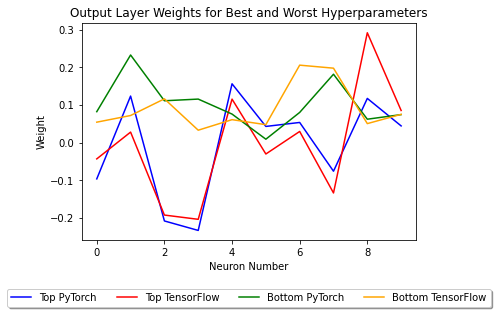

In [101]:
ax = plt.gca()
ax.plot(list(range(10)), mean_top_pt, color="blue", label="Top PyTorch")
ax.plot(list(range(10)), mean_top_tf, color="red", label="Top TensorFlow")
ax.plot(list(range(10)), mean_bottom_pt, color="green", label="Bottom PyTorch")
ax.plot(list(range(10)), mean_bottom_tf, color="orange", label="Bottom TensorFlow")
ax.set_title("Output Layer Weights for Best and Worst Hyperparameters")
ax.set_xlabel("Neuron Number")
ax.set_ylabel("Weight")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [115]:
np.array(top_pt).std(axis=0)

array([0.05561265, 0.0559086 , 0.06509434, 0.06800444, 0.06590966,
       0.05530198, 0.052506  , 0.06709471, 0.05545956, 0.06077011],
      dtype=float32)

In [116]:
np.array(top_tf).std(axis=0)

array([0.04893296, 0.05515404, 0.05572626, 0.0621965 , 0.05368591,
       0.05521747, 0.06180924, 0.05643507, 0.0538887 , 0.04957468],
      dtype=float32)

In [117]:
np.array(bottom_pt).std(axis=0)

array([0.0265768 , 0.02685711, 0.02657658, 0.02654445, 0.02655871,
       0.02658228, 0.02656467, 0.02654975, 0.02658105, 0.02656422],
      dtype=float32)

In [118]:
np.array(bottom_tf).std(axis=0)

array([0.14651692, 0.12447508, 0.1276609 , 0.12100063, 0.13478841,
       0.13689716, 0.12248106, 0.12834208, 0.1491098 , 0.11949101],
      dtype=float32)